In [1]:
import sys 
sys.path.insert(0,'/home/mohit/Downloads/code_notebooks/deep_boltzmann')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import ParticleDimer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet, create_RealNVPNet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.sampling.latent_sampling import BiasedModel
from deep_boltzmann.sampling.permutation import HungarianMapper
from deep_boltzmann.util import load_obj, save_obj
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [6]:
trajdict = np.load('output.npz')
import ast
#params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

In [7]:
model = ParticleDimer()

In [8]:
noise_intensity = 0.0
X0 = np.vstack([traj_closed_train, traj_open_train])
Nnoise = xval.shape[0]
X0noise = X0[np.random.choice(X0.shape[0], Nnoise)] + noise_intensity * np.random.randn(Nnoise, X0.shape[1])
X0noise = X0noise.astype(np.float32)

In [9]:
print(X0)
print(Nnoise)
print(X0noise)

[[-0.25        0.          0.25       ...  1.8         3.
   3.        ]
 [-0.25        0.          0.25       ...  1.8         3.
   3.        ]
 [-0.25        0.          0.25       ...  1.8         3.
   3.        ]
 ...
 [-1.0630857  -0.05359605  1.0554433  ...  1.7124369   3.0444221
   2.9039712 ]
 [-1.0630857  -0.05359605  1.0554433  ...  1.7124369   3.0444221
   2.9039712 ]
 [-1.0630857  -0.05359605  1.0554433  ...  1.7124369   3.0444221
   2.9039712 ]]
200002
[[-0.52417773 -0.04789994  0.45717064 ...  1.7877358   2.8287694
   2.9810314 ]
 [-0.36073744 -0.03763573  0.6185857  ...  1.7788365   3.0659313
   3.055591  ]
 [-1.0784731   0.22362003  0.9872182  ...  1.5509019   3.0341654
   2.7259614 ]
 ...
 [-0.52378035  0.1047413   0.36720967 ...  2.0443313   3.034603
   3.0862508 ]
 [-1.0111333   0.01884039  0.90959877 ...  1.4149508   2.9712985
   2.6166167 ]
 [-1.0691972   0.15174706  0.98819613 ...  1.4781332   2.8939245
   3.0340357 ]]


In [10]:
def load(filename, energy_model, clear_session=True):
        """ Loads parameters into model. Careful: this clears the whole TF session!!
        """
        from deep_boltzmann.util import load_obj
        if clear_session:
                keras.backend.clear_session()
        D = load_obj(filename)
        prior = D['prior']
        layerdicts = D['layers']
        layers = [eval(d['type']).from_dict(d) for d in layerdicts]
        return EnergyInvNet(energy_model, layers, prior=prior)

In [11]:
bg = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=200, #100
            nl_activation='relu', nl_activation_scale='tanh', whiten=X0noise)
bg = bg.load('ClosedParticleModel.pkl',model)

W<RRRRRRRR>
W 76 0 0
[-0.74600506  0.02892446  0.73571926  0.06609654 -2.9585288  -2.9469764
 -2.955018   -1.7582105  -2.9382997  -0.54429483 -2.8513455   0.639563
 -2.866121    1.72128    -2.946442    2.936355   -1.8219231  -2.9904175
 -1.7504138  -1.8492539  -1.8563002  -0.5527873  -1.7423866   0.66564095
 -1.7624011   1.8477739  -1.7353451   2.9812696  -0.6455448  -2.933331
 -0.42973325 -1.8638654  -0.74473107 -0.9515301  -0.4222205   0.8539142
 -0.70237136  1.8794507  -0.5020124   2.9879923   0.55521333 -3.00748
  0.7301136  -1.929642    0.53427875 -0.9525112   0.7104615   0.8213376
  0.47351006  1.8246245   0.7046752   2.9225461   1.7813154  -2.9414043
  1.8177681  -1.7313229   1.8181711  -0.5524219   1.9459414   0.63988096
  1.8132775   1.8715482   1.8060806   2.945477    2.9353027  -2.9869335
  2.923977   -1.8644753   2.9636972  -0.7172182   2.9987218   0.5040684
  2.9638493   1.7208413   2.9586756   2.9161727 ]
< 76 0 0
R 38 38 0

R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38

In [15]:
print(bg.transform_xz(np.array(traj_closed_train[100])))

[[ 1.8081965  -0.39243084 -3.9082623   1.0022087  -0.0144608  -5.3975377
   1.5871834  -1.3803861   0.62542963 -0.2918049   0.4638555   3.7898097
   3.0023677  -0.41737485  0.67941046 -1.1000729  -0.9461811   1.115367
   0.5063507   1.1997495   1.0032647   1.0835241  -0.69395244  2.9468894
   0.0465973  -1.3527902   1.975056    2.3977928   0.21169102 -0.18565558
  -0.7010404   3.226686    5.069151    1.5203862  -2.8654964  -4.174064
  -0.03717697 -1.4781804   0.7994498  -0.6581282   0.51603484 -2.8374038
   4.770503    1.9798747   0.02973366  2.6277518  -5.4410133  -1.3397837
  -2.5449748  -1.2870793  -1.7286024  -0.5367125  -0.19506301  1.4476544
   2.6229634   1.2061212   0.8847171  -3.522863    0.5170662  -2.3469872
  -1.7286739  -2.4278257  -0.13978273 -1.6356236  -1.0335028   2.2358012
  -0.7267504  -2.1497622  -2.0117483   1.4698668  -5.007353   -0.7479942
  -3.150476    2.0692775  -1.9959269   2.7299488 ]]


In [16]:
def latent_interpolation(bg, x1, x2, nstep=1000, through_origin=False):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    if through_origin:
        zpath1 = z1 * (1-lambdas[::2])
        zpath2 = z2 * (lambdas[::2]) 
        zpath = np.vstack([zpath1, zpath2])
    else:
        zpath = z1 + lambdas*(z2-z1)
    xpath = bg.transform_zx(zpath)
    return xpath

In [17]:
Emin = 1e9
Ep = []
bestpath = None
for i in range(90):
    for j in range(90):
        path = latent_interpolation(bg, traj_closed_train[i*100+5000], traj_open_train[j*100+5000], nstep=9)
        E = model.energy(path).max()
        Ep.append(E)
        if E < Emin:
            Emin = E
            bestpath = path

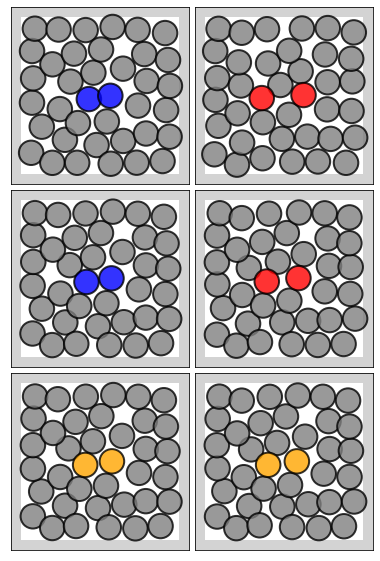

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6.5, 10))
model.draw_config(bestpath[0], axis=axes[0, 0], dimercolor='blue', alpha=0.8);
model.draw_config(bestpath[2], axis=axes[1, 0], dimercolor='blue', alpha=0.8);
model.draw_config(bestpath[3], axis=axes[2, 0], dimercolor='orange', alpha=0.8);
model.draw_config(bestpath[4], axis=axes[2, 1], dimercolor='orange', alpha=0.8);
model.draw_config(bestpath[5], axis=axes[1, 1], dimercolor='red', alpha=0.8);
model.draw_config(bestpath[7], axis=axes[0, 1], dimercolor='red', alpha=0.8);
plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.savefig('interpolate.pdf', bbox_inches='tight')

In [16]:
print(np.mean( Ep ) )

4.0594767451744067e+21


In [17]:
print(Ep)

[307837.40625, 622911.125, 3125847.5, 730762.4375, 14051.41796875, 45961472.0, 115492.6640625, 24625.83984375, 414.9793701171875, 1276.957275390625, 67343.5859375, 141322960.0, 428629.6875, 180545584.0, 44835908.0, 4696014336.0, 186437014126592.0, 1.3647068745485517e+17, 2.716439862178358e+24, 27513268224.0, 2344043.75, 9352645632.0, 3189495.75, 11391232000.0, 3109557760.0, 5138576896.0, 1899231.125, 139938.09375, 1729158528.0, 2931748352.0, 206107408.0, 226994736.0, 107260568.0, 56882.65625, 399638016.0, 10121.47265625, 18362797129728.0, 572340928.0, 1587.857177734375, 1392.962890625, 8849.177734375, 2.4983342350105313e+18, 2361080576.0, 1007376.375, 820854.4375, 52434726912.0, 191407440.0, 22571.84765625, 74490200.0, 96996080.0, 31561.986328125, 2408657920.0, 2659579068416.0, 1801075072.0, 1.928444439072604e+17, 673517712441344.0, 893083285716992.0, 7449.0390625, 620425510912.0, 3390599168.0, 6525023232.0, 11107999678464.0, 56646024.0, 9947.630859375, 1713060352.0, 13288087552.0, 352

In [19]:
closed= []
for sample in traj_closed_test:
    closed.append(bg.transform_xz(sample))

In [20]:
openState = []
for sample in traj_open_test:
    openState.append(bg.transform_xz(sample))

In [20]:
cMean = np.array(closed).mean()

In [21]:
closed = np.array(closed)[:,0]

In [21]:
print(closed.std(axis = 0))

AttributeError: 'list' object has no attribute 'std'

In [23]:
openState = np.array(openState)[:,0]

In [24]:
print(openState.std(axis=0))

[2.4810996  0.992375   1.7034141  1.4246875  0.9557768  0.97892547
 1.1125358  0.78729963 1.3011736  0.8132808  1.1063586  1.141026
 1.169036   1.0436308  1.1560506  1.0148121  1.2552208  0.99598336
 1.3114549  1.04059    1.0955861  1.0523968  1.0043676  1.4293263
 0.89874524 1.3023179  1.1593091  0.81285524 1.107356   0.8307228
 1.6049628  2.6764524  1.6966507  2.0487645  1.0903562  1.6289892
 1.0307783  1.7349349  1.3798547  0.89716774 1.0640627  0.89075804
 1.6719654  1.2906175  1.0693619  1.0831584  2.0717964  2.4336612
 1.7235719  1.1093659  0.94254744 0.9164993  1.3462212  1.2634364
 1.3913063  1.5082378  1.1928785  1.2377508  1.0904739  1.0489057
 0.9914543  0.8963614  1.0608237  0.86857635 1.1878804  1.2779057
 1.0488402  1.0814147  1.2654879  1.1615394  1.0060004  0.894433
 1.6273798  1.1341993  0.86170673 1.5702106 ]


In [25]:
print(openState.mean(axis = 0))

[-3.3890934  -0.93177646  0.30287716  0.06298126  3.2721364  -0.17091863
  1.3817397   0.7011506   0.41241685  0.61047727  1.6519699   0.97067887
  3.2684765  -0.6429341   1.7864614  -2.2615535   0.64430124  0.01241075
  1.3481106   1.2133399  -1.2270364   1.2917268  -2.034433    1.6207387
  0.95185727 -3.1440494   0.98464084 -1.7560964   3.0210435   1.3069154
  0.18464454  3.0307374   1.7291274   0.14631674 -0.58031106 -1.0174762
  0.6032931  -2.0709097   1.0418918  -0.13960488 -0.00833397 -0.6406844
  1.9046565   1.6406168  -3.7399652   2.0289757  -2.0554585  -1.3310332
 -1.5503207   0.44104958 -0.20610137  0.43890843  0.8082743   3.2735667
 -0.5928566  -0.45345536 -0.15527849 -1.129259    0.30773887  0.08883974
 -0.88947594 -0.9594644   0.33370823 -1.5920572  -2.3084805   0.6963172
 -1.8719425   2.1816182  -1.2664376  -0.34860942 -4.0546737  -0.15605843
 -4.629533   -0.03551815 -1.1674342  -1.4194925 ]


In [26]:
from sklearn.decomposition import PCA
nf = 2
pca = PCA(n_components=nf)
pca.fit(openState)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)